## Import Data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [2]:
pd.set_option('display.max_columns',500)

In [3]:
col_names = ["Ediblity","Cap-shape","Cap-surface","Cap-color","Bruises?",
             "Odor","Gill-attachment","Gill-spacing","Gill-size","Gill-color",
             "Stalk-shape","Stalk-root","Stalk-surface-above-ring","Stalk-surface-below-ring",
             "Stalk-color-above-ring","Stalk-color-below-ring","Veil-type","Veil-color",
             "Ring-number","Ring-type","Spore-print-color","Population","Habitat"]
html = "agaricus-lepiota.data"

df = pd.read_csv(html, header=None, names=col_names)
df.head()


,Ediblity,Cap-shape,Cap-surface,Cap-color,Bruises?,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-type,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [4]:
# check to make sure the '?' converted to null values'
df.isnull().sum()

Ediblity                    0
Cap-shape                   0
Cap-surface                 0
Cap-color                   0
Bruises?                    0
Odor                        0
Gill-attachment             0
Gill-spacing                0
Gill-size                   0
Gill-color                  0
Stalk-shape                 0
Stalk-root                  0
Stalk-surface-above-ring    0
Stalk-surface-below-ring    0
Stalk-color-above-ring      0
Stalk-color-below-ring      0
Veil-type                   0
Veil-color                  0
Ring-number                 0
Ring-type                   0
Spore-print-color           0
Population                  0
Habitat                     0
dtype: int64

### Convert Data to be more readable

In [5]:
df['Ediblity'] = df['Ediblity'].replace({'p':0,'e':1})
df['Cap-shape'] = df['Cap-shape'].replace({'b':'bell','c':'conical','x':'convex','f':'flat','k':'knobbed','s':'sunken'})
df['Cap-surface'] = df['Cap-surface'].replace({'f':'fibrous','g':'grooves','y':'scaly','s':'smooth'})
df['Cap-color'] = df['Cap-color'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
df['Bruises?'] = df['Bruises?'].replace({'t':1,'f':0})
df['Odor'] = df['Odor'].replace({'a':'almond','l':'anise','c':'creosote','y':'fishy','f':'foul','m':'musty','n':'none','p':'pungent','s':'spicy'})
df['Gill-attachment'] = df['Gill-attachment'].replace({'a':'attached','d':'descending','f':'free','n':'notched'})
df['Gill-spacing'] = df['Gill-spacing'].replace({'c':'close','w':'crowded','d':'distant'})
df['Gill-size'] = df['Gill-size'].replace({'b':'broad','n':'narrow'})
df['Gill-color'] = df['Gill-color'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','k':'black','o':'orange'})
df['Stalk-shape'] = df['Stalk-shape'].replace({'e':'enlarging','t':'tapering'})
df['Stalk-root'] = df['Stalk-root'].replace({'b':'bulbous','c':'club','u':'cup','e':'equal','z':'rhizomorphs','r':'rooted'})
df['Stalk-surface-above-ring'] = df['Stalk-surface-above-ring'].replace({'f':'fibrous','y':'scaly','k':'silky','s':'smooth'})
df['Stalk-surface-below-ring'] = df['Stalk-surface-below-ring'].replace({'f':'fibrous','y':'scaly','k':'silky','s':'smooth'})
df['Stalk-color-above-ring'] = df['Stalk-color-above-ring'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
df['Stalk-color-below-ring'] = df['Stalk-color-below-ring'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
df['Veil-color'] = df['Veil-color'].replace({'n':'brown','o':'orange','w':'white','y':'yellow'})
df['Ring-number'] = df['Ring-number'].replace({'n':0,'o':1,'t':2})
df['Ring-type'] = df['Ring-type'].replace({'c':'cobwebby','e':'evanescent','f':'flaring','l':'large','n':'none','p':'pendant','s':'sheathing','z':'zone'})
df['Spore-print-color'] = df['Spore-print-color'].replace({'k':'black','n':'brown','b':'buff','h':'chocolate','r':'green','o':'orange','u':'purple','w':'white','y':'yellow'})
df['Population'] = df['Population'].replace({'a':'abundant','c':'clustered','n':'numerous','s':'scattered','v':'several','y':'solitary'})
df['Habitat'] = df['Habitat'].replace({'g':'grasses','l':'leaves','m':'meadows','p':'paths','u':'urban','w':'waste','d':'woods'})

## Split the data into train, val, and test

In [6]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    # Three way split using a function I found at 
    #   https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    #   by user piRSquared

    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, val, test = train_validate_test_split(df, seed=35177)

print(train.shape, val.shape, test.shape)

import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(train,minimal=True)

# profile.to_notebook_iframe()
profile.to_file(output_file='mushroom_classification_data_profile.html')

(4874, 23) (1624, 23) (1626, 23)


In [7]:
train.head(5)

,Ediblity,Cap-shape,Cap-surface,Cap-color,Bruises?,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-type,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat
4838,0,convex,fibrous,yellow,0,foul,free,close,broad,gray,enlarging,bulbous,silky,silky,buff,brown,p,white,1,large,chocolate,solitary,woods
4873,0,flat,scaly,gray,0,foul,free,close,broad,gray,enlarging,bulbous,silky,silky,pink,buff,p,white,1,large,chocolate,solitary,grasses
6644,0,convex,smooth,red,0,fishy,free,close,narrow,buff,tapering,?,smooth,silky,white,pink,p,white,1,evanescent,white,several,woods
6486,0,flat,smooth,red,0,spicy,free,close,narrow,buff,tapering,?,smooth,silky,pink,white,p,white,1,evanescent,white,several,leaves
277,1,convex,scaly,white,1,almond,free,close,broad,white,enlarging,club,smooth,smooth,white,white,p,white,1,pendant,brown,numerous,meadows


## Wrangle the data and create features

In [8]:
def wrangle(X):
    X = X.copy()
    
    # drop the veil type because it has a constant value and Odor because it is too subjective
    X = X.drop(columns=['Veil-type','Odor'])
    
    # create new features
    # Uniform Stalk Color
    X.loc[(X['Stalk-color-above-ring']==X['Stalk-color-below-ring']), 'Uniform-stalk-color'] = 1
    X.loc[(X['Stalk-color-above-ring']!=X['Stalk-color-below-ring']), 'Uniform-stalk-color'] = 0
    X["Uniform-stalk-color"] = X["Uniform-stalk-color"].astype(int)
    # Uniform Salk Surface
    X.loc[(X['Stalk-surface-above-ring']==X['Stalk-surface-below-ring']), 'Uniform-stalk-surface'] = 1
    X.loc[(X['Stalk-surface-above-ring']!=X['Stalk-surface-below-ring']), 'Uniform-stalk-surface'] = 0
    X["Uniform-stalk-surface"] = X["Uniform-stalk-surface"].astype(int)
    
    # Pleasant Oder (took this out because it was too predictive of the edibility and too subjective
    #                in interpritation)
    #X['Pleasant-odor'] = [1 if (x == 'almond' or x == 'anise' or x == 'none') else 0 for x in X['Odor']]
    
    
    return X

In [9]:
wrangle(train).dtypes

Ediblity                     int64
Cap-shape                   object
Cap-surface                 object
Cap-color                   object
Bruises?                     int64
Gill-attachment             object
Gill-spacing                object
Gill-size                   object
Gill-color                  object
Stalk-shape                 object
Stalk-root                  object
Stalk-surface-above-ring    object
Stalk-surface-below-ring    object
Stalk-color-above-ring      object
Stalk-color-below-ring      object
Veil-color                  object
Ring-number                  int64
Ring-type                   object
Spore-print-color           object
Population                  object
Habitat                     object
Uniform-stalk-color          int32
Uniform-stalk-surface        int32
dtype: object

In [10]:
w_train = wrangle(train)
w_val = wrangle(val)
w_test = wrangle(test)

In [11]:
# set the target and features
target = 'Ediblity'
features = w_train.drop(columns=target).columns.tolist()

#create an X and y for each set
X_train = w_train[features]
y_train = w_train[target]
X_val = w_val[features]
y_val = w_val[target]
X_test = w_test[features]
y_test = w_test[target]

In [12]:
X_val=X_val.reset_index(drop=True)
y_val=y_val.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True);

In [13]:
X_train.head()

,Cap-shape,Cap-surface,Cap-color,Bruises?,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat,Uniform-stalk-color,Uniform-stalk-surface
0,convex,fibrous,yellow,0,free,close,broad,gray,enlarging,bulbous,silky,silky,buff,brown,white,1,large,chocolate,solitary,woods,0,1
1,flat,scaly,gray,0,free,close,broad,gray,enlarging,bulbous,silky,silky,pink,buff,white,1,large,chocolate,solitary,grasses,0,1
2,convex,smooth,red,0,free,close,narrow,buff,tapering,?,smooth,silky,white,pink,white,1,evanescent,white,several,woods,0,0
3,flat,smooth,red,0,free,close,narrow,buff,tapering,?,smooth,silky,pink,white,white,1,evanescent,white,several,leaves,0,0
4,convex,scaly,white,1,free,close,broad,white,enlarging,club,smooth,smooth,white,white,white,1,pendant,brown,numerous,meadows,1,1


## Find the baseline

In [14]:
# Use the dummy classifier to estimate the most frequent result all the time.
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_val)
accuracy_score(y_val,y_pred)

0.5227832512315271

The baseline score would be 52.28%

## Use Permutation Importances

In [15]:
# separate the pipeline out  so that we can use the
# Permutation importance
transformers = make_pipeline(
                ce.OrdinalEncoder())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(max_depth=10,random_state=7)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [16]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=10,
    random_state=7
)

permuter.fit(X_val_transformed,y_val);

C:\Users\kelsi\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\kelsi\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [17]:
# set feature names to a variable
feature_names = X_val.columns.tolist()
# show the weights for each column
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0650 ± 0.0094,Spore-print-color
0.0493 ± 0.0085,Gill-size
0.0028 ± 0.0025,Stalk-shape
0.0017 ± 0.0014,Cap-surface
0.0011 ± 0.0013,Habitat
0.0005 ± 0.0009,Bruises?
0.0002 ± 0.0006,Stalk-root
0.0001 ± 0.0004,Stalk-surface-above-ring
0 ± 0.0000,Cap-color
0 ± 0.0000,Gill-attachment


## Make a model using Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression

lr_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LinearRegression()
)


lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_val)
print('Validation Score:', lr_pipe.score(X_val,y_val))

Validation Score: 0.7911422972111041


## Make another model with XGBoost

In [19]:
# Run XGBoost with basic Parameters

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xg_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=7, n_jobs=-1)
)
xg_pipe.fit(X_train,y_train)

y_pred = xg_pipe.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val,y_pred))
y_pred_proba = xg_pipe.predict_proba(X_val)[:,-1]
print('AUC ROC Score:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy: 1.0
AUC ROC Score: 1.0


### Permutation Importance using the XGBoost model

In [20]:
permuter = PermutationImportance(
    xg_pipe,
    scoring='roc_auc',
    n_iter=10,
    random_state=42
)

permuter.fit(X_val_transformed,y_val);

# set feature names to a variable
feature_names = X_val.columns.tolist()
# show the weights for each column
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.2213 ± 0.0132,Bruises?
0.0795 ± 0.0102,Ring-number
0 ± 0.0000,Uniform-stalk-surface
0 ± 0.0000,Stalk-root
0 ± 0.0000,Cap-surface
0 ± 0.0000,Cap-color
0 ± 0.0000,Gill-attachment
0 ± 0.0000,Gill-spacing
0 ± 0.0000,Gill-size
0 ± 0.0000,Gill-color


### Confusion Matrix from the above model

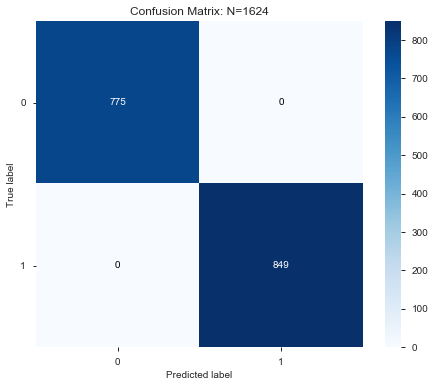

In [21]:
# plot the Confusion Matrix
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_val, y_pred,
    figsize=(8,6),
    title=f'Confusion Matrix: N={len(y_val)}',
    normalize=False
    );
plt.savefig('confusion_matrix.png')

### Plot Coefficiant Corilation to try to find Data Leakage

In [43]:
# Combine the wrangled data to get a full dataset to look for leakage

full = pd.concat([w_train,w_val,w_test])
print(full.columns)
full.head()

Index(['Ediblity', 'Cap-shape', 'Cap-surface', 'Cap-color', 'Bruises?',
       'Gill-attachment', 'Gill-spacing', 'Gill-size', 'Gill-color',
       'Stalk-shape', 'Stalk-root', 'Stalk-surface-above-ring',
       'Stalk-surface-below-ring', 'Stalk-color-above-ring',
       'Stalk-color-below-ring', 'Veil-color', 'Ring-number', 'Ring-type',
       'Spore-print-color', 'Population', 'Habitat', 'Uniform-stalk-color',
       'Uniform-stalk-surface'],
      dtype='object')


,Ediblity,Cap-shape,Cap-surface,Cap-color,Bruises?,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat,Uniform-stalk-color,Uniform-stalk-surface
4838,0,convex,fibrous,yellow,0,free,close,broad,gray,enlarging,bulbous,silky,silky,buff,brown,white,1,large,chocolate,solitary,woods,0,1
4873,0,flat,scaly,gray,0,free,close,broad,gray,enlarging,bulbous,silky,silky,pink,buff,white,1,large,chocolate,solitary,grasses,0,1
6644,0,convex,smooth,red,0,free,close,narrow,buff,tapering,?,smooth,silky,white,pink,white,1,evanescent,white,several,woods,0,0
6486,0,flat,smooth,red,0,free,close,narrow,buff,tapering,?,smooth,silky,pink,white,white,1,evanescent,white,several,leaves,0,0
277,1,convex,scaly,white,1,free,close,broad,white,enlarging,club,smooth,smooth,white,white,white,1,pendant,brown,numerous,meadows,1,1


In [47]:
# Manually ordinal encode my data so that it will work fro the heatmap

full['Cap-shape'] = full['Cap-shape'].replace({'bell':0,'conical':1,'convex':3,'flat':4,'knobbed':5,'sunken':6})
full['Cap-surface'] = full['Cap-surface'].replace({'fibrous':0,'grooves':1,'scaly':2,'smooth':4})
full['Cap-color'] = full['Cap-color'].replace({'brown':0,'buff':1,'cinnamon':2,'gray':3,'green':4,'pink':5,'purple':6,'red':7,'white':8,'yellow':9})
full['Gill-attachment'] = full['Gill-attachment'].replace({'attached':0,'descending':1,'free':2,'notched':3})
full['Gill-spacing'] = full['Gill-spacing'].replace({'close':0,'crowded':1,'distant':1})
full['Gill-size'] = full['Gill-size'].replace({'broad':0,'narrow':1})
full['Gill-color'] = full['Gill-color'].replace({'brown':0,'buff':1,'cinnamon':2,'gray':3,'green':4,'pink':5,'purple':6,'red':7,'white':8,'yellow':9,'black':10,'orange':11})
full['Stalk-shape'] = full['Stalk-shape'].replace({'enlarging':0,'tapering':1})
full['Stalk-root'] = full['Stalk-root'].replace({'bulbous':0,'club':1,'cup':2,'equal':3,'rhizomorphs':4,'rooted':5,'?':6})
full['Stalk-surface-above-ring'] = full['Stalk-surface-above-ring'].replace({'fibrous':0,'scaly':1,'silky':2,'smooth':3})
full['Stalk-surface-below-ring'] = full['Stalk-surface-below-ring'].replace({'fibrous':0,'scaly':1,'silky':2,'smooth':3})
full['Stalk-color-above-ring'] = full['Stalk-color-above-ring'].replace({'brown':0,'buff':1,'cinnamon':2,'gray':3,'green':4,'pink':5,'purple':6,'red':7,'white':8,'yellow':9})
full['Stalk-color-below-ring'] = full['Stalk-color-below-ring'].replace({'brown':0,'buff':1,'cinnamon':2,'gray':3,'green':4,'pink':5,'purple':6,'red':7,'white':8,'yellow':9})
full['Veil-color'] = full['Veil-color'].replace({'brown':0,'orange':1,'white':2,'yellow':3})
full['Ring-type'] = full['Ring-type'].replace({'cobwebby':0,'evanescent':1,'flaring':2,'large':3,'none':4,'pendant':5,'sheathing':6,'zone':7})
full['Spore-print-color'] = full['Spore-print-color'].replace({'black':0,'brown':1,'buff':2,'chocolate':3,'green':4,'orange':5,'purple':6,'white':7,'yellow':8})
full['Population'] = full['Population'].replace({'abundant':0,'clustered':1,'numerous':2,'scattered':3,'several':4,'solitary':5})
full['Habitat'] = full['Habitat'].replace({'grasses':0,'leaves':1,'meadows':2,'paths':3,'urban':4,'waste':5,'woods':6})

In [51]:
full.head()

,Ediblity,Cap-shape,Cap-surface,Cap-color,Bruises?,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat,Uniform-stalk-color,Uniform-stalk-surface
4838,0,3,0,9,0,2,0,0,3,0,0,2,2,1,0,2,1,3,3,5,6,0,1
4873,0,4,2,3,0,2,0,0,3,0,0,2,2,5,1,2,1,3,3,5,0,0,1
6644,0,3,4,7,0,2,0,1,1,1,6,3,2,8,5,2,1,1,7,4,6,0,0
6486,0,4,4,7,0,2,0,1,1,1,6,3,2,5,8,2,1,1,7,4,1,0,0
277,1,3,2,8,1,2,0,0,8,0,1,3,3,8,8,2,1,5,1,2,2,1,1


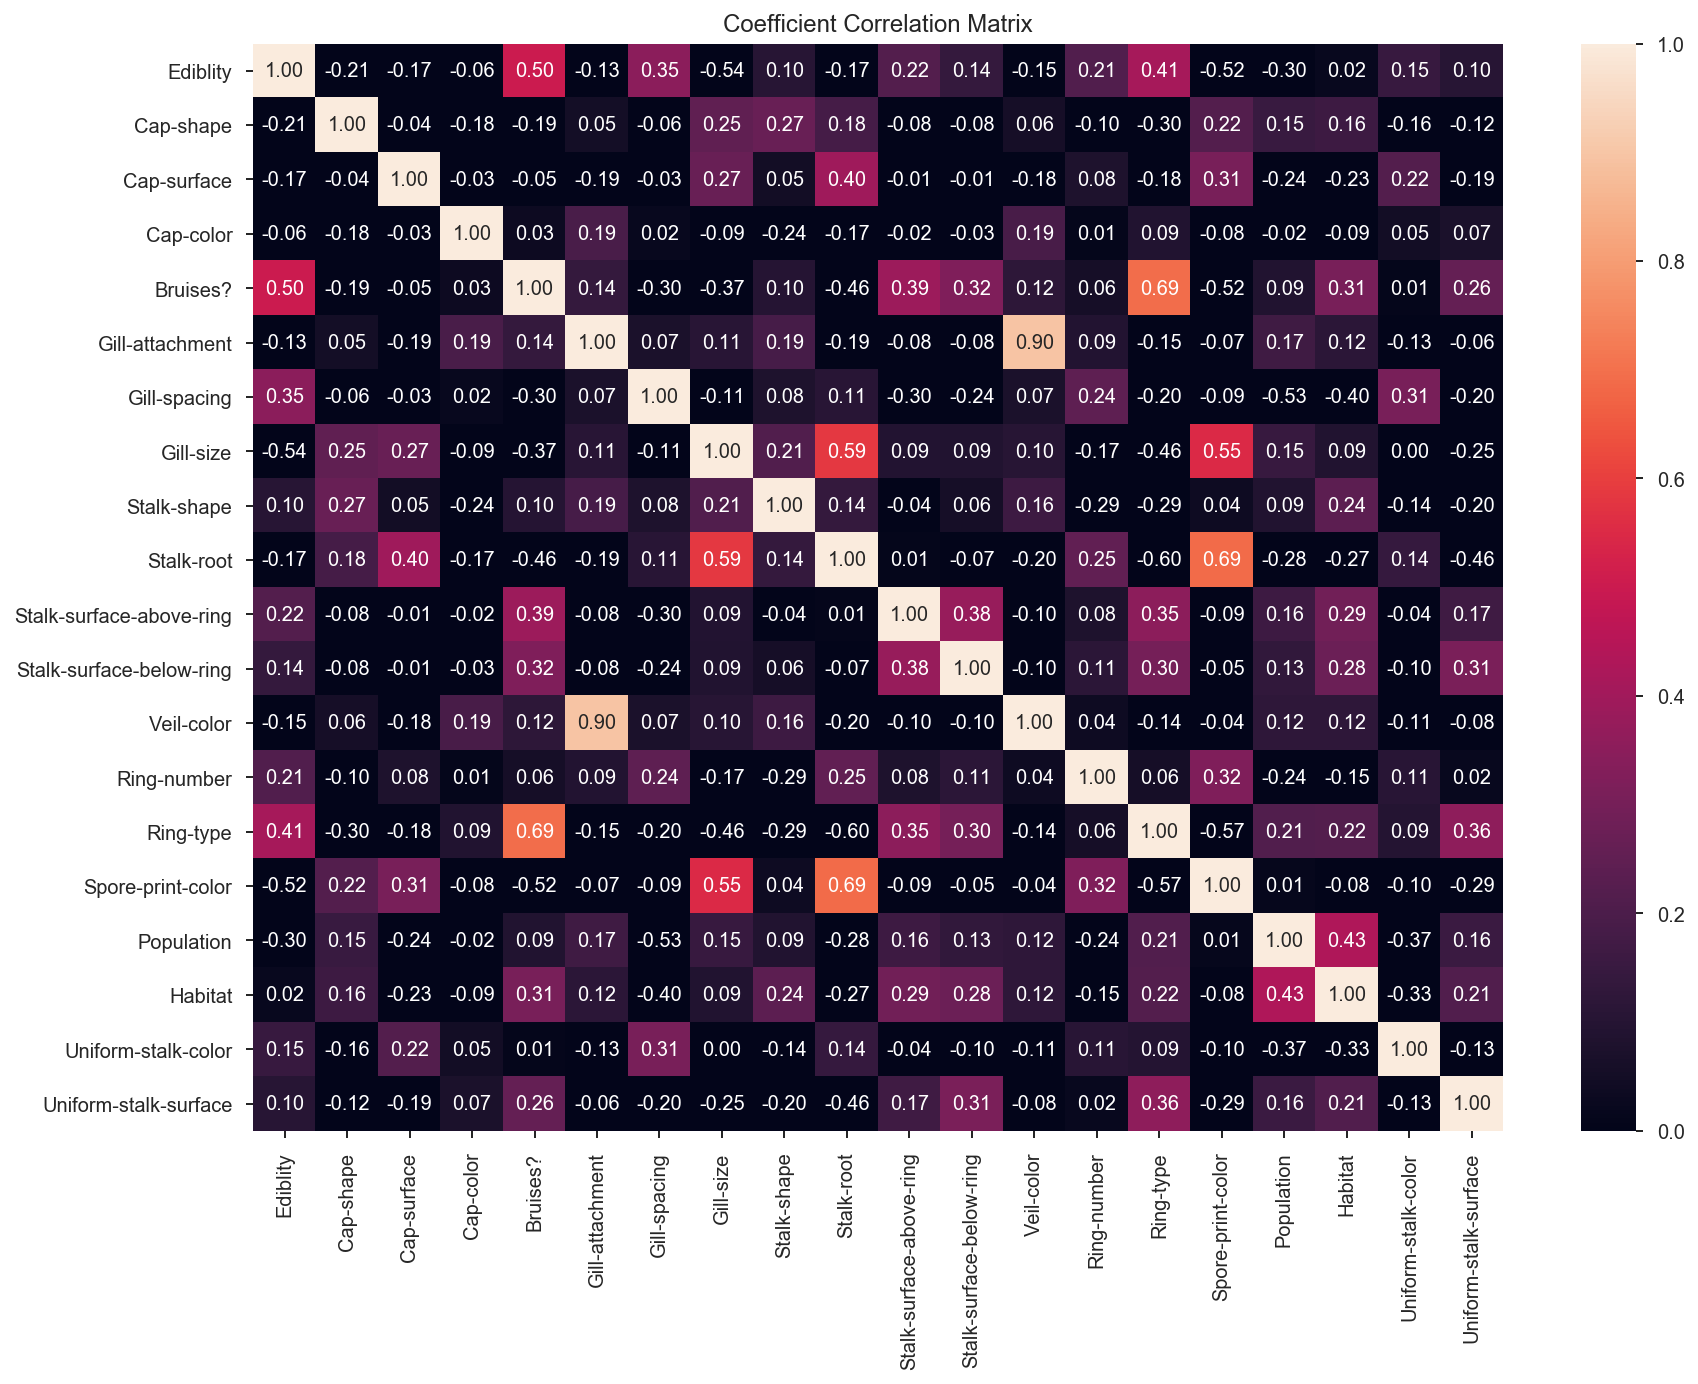

In [55]:
import seaborn as sns

#set up the matrix
fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(full.corr(),0,1,ax=ax,annot=True,fmt="0.2f").set_title("Coefficient Correlation Matrix")

# save the plot for later use and show it here.
plt.savefig('coefficient_correlation_matrix.png')
plt.show()

## One final Test Score with XGBoost

In [22]:
xg_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=7, n_jobs=-1)
)
xg_pipe.fit(X_train,y_train)

y_pred = xg_pipe.predict(X_test)
print('Validation Accuracy:', accuracy_score(y_test,y_pred))
y_pred_proba = xg_pipe.predict_proba(X_test)[:,-1]
print('AUC ROC Score:', roc_auc_score(y_test, y_pred_proba))

Validation Accuracy: 1.0
AUC ROC Score: 1.0


## Shapley Force Plots

In [23]:
# set up matplotlib for the graphs (double it when using the image for the blog post)
plt.rcParams['figure.dpi'] = 144

In [24]:
import shap

# set the processor and model to be used in the next cell's function
processor = make_pipeline(
    ce.OrdinalEncoder()
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]
            
model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train_processed,y_train);

In [25]:
def explain(row_number):
  positive_class = 1
  positive_class_index = 1

  # Get & process the data for the row
  row = X_test.iloc[[row_number]]
  row_processed = processor.transform(row)

  # Make predictions
  pred = model.predict(row_processed)[0]
  if pred == 1:
    pred = "Edible"
    positive_class = "Edible"
  else:
    pred = "Poisonous"
    positive_class = "Edible"

  pred_proba = model.predict_proba(row_processed)[0, positive_class_index] 
  pred_proba *= 100
  if pred != positive_class:
    pred_proba = 100 - pred_proba
  
  # show prediction and probability
  print(f'The model predicts this mushroom is "{pred}", with a {pred_proba:.0f}% probability.')

  actual = y_test.iloc[row_number]
  if actual == 1:
    print('The actual value is "Edible"')
  else:
    print('The actual value is "Posionous"')

  # Get shapley additive explanations
  
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(row_processed)

  # Get the top 3 "pros and cons"
  feature_names =row.columns
  feature_values = row.values[0]
  shaps = pd.Series(shap_values[0], zip(feature_names,feature_values))
  pros = shaps.sort_values(ascending=False)[:3].index
  cons = shaps.sort_values(ascending=True)[:3].index

  # Show top 3 reasons for predictions
  print('\nTop 3 reasons for prediction:')
  evidence = pros if pred == positive_class else cons
  for i, info in enumerate(evidence, start=1):
    feature_name, feature_value = info
    print(f'{i}. {feature_name} is {feature_value}.')
  
  # Show top 1 counter-argument against prediction
  print('\nTop counter-argument against prediction:')
  evidence = cons if pred == positive_class else pros
  feature_name, feature_value = evidence[0]
  print(f'- {feature_name} is {feature_value}.')

  # show the shapley values force plot
  shap.initjs()
  return shap.force_plot(
      base_value=explainer.expected_value,
      shap_values=shap_values,
      features=row,
      link='logit' # shows probabilities for classification
  )

In [26]:
explain(4)

The model predicts this mushroom is "Edible", with a 100% probability.
The actual value is "Edible"

Top 3 reasons for prediction:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



1. Gill-size is broad.
2. Spore-print-color is black.
3. Gill-spacing is crowded.

Top counter-argument against prediction:
- Cap-surface is smooth.


In [27]:
explain(500)

The model predicts this mushroom is "Poisonous", with a 100% probability.
The actual value is "Posionous"

Top 3 reasons for prediction:
1. Spore-print-color is chocolate.
2. Stalk-surface-above-ring is silky.
3. Gill-color is gray.

Top counter-argument against prediction:
- Cap-surface is fibrous.


In [28]:
explain(1032)

The model predicts this mushroom is "Poisonous", with a 87% probability.
The actual value is "Posionous"

Top 3 reasons for prediction:
1. Gill-size is narrow.
2. Stalk-color-below-ring is yellow.
3. Spore-print-color is white.

Top counter-argument against prediction:
- Gill-spacing is crowded.


In [29]:
explain(80)

The model predicts this mushroom is "Poisonous", with a 92% probability.
The actual value is "Posionous"

Top 3 reasons for prediction:
1. Ring-number is 2.
2. Stalk-root is bulbous.
3. Stalk-shape is enlarging.

Top counter-argument against prediction:
- Gill-size is broad.
